<a href="https://colab.research.google.com/github/Akshatha7710/telco-customer-churn/blob/main/telco_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TELCO CHURN PREDICTION - COURSEWORK IMPLEMENTATION

1. LOADING AND CLEANING DATA
------------------------------
Dataset: 7043 rows, 21 columns

2. ESSENTIAL EXPLORATORY ANALYSIS
------------------------------


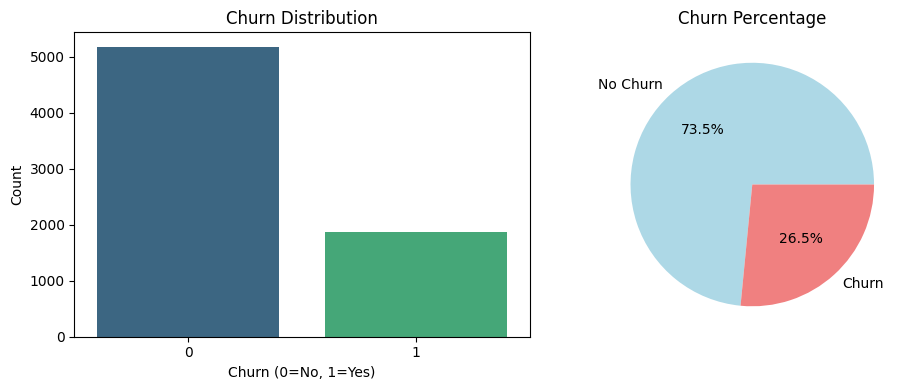

Churn rate: 26.5% (1869/7043)


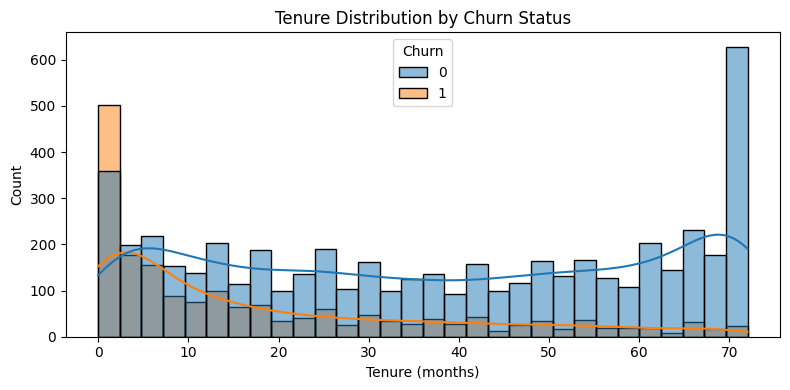

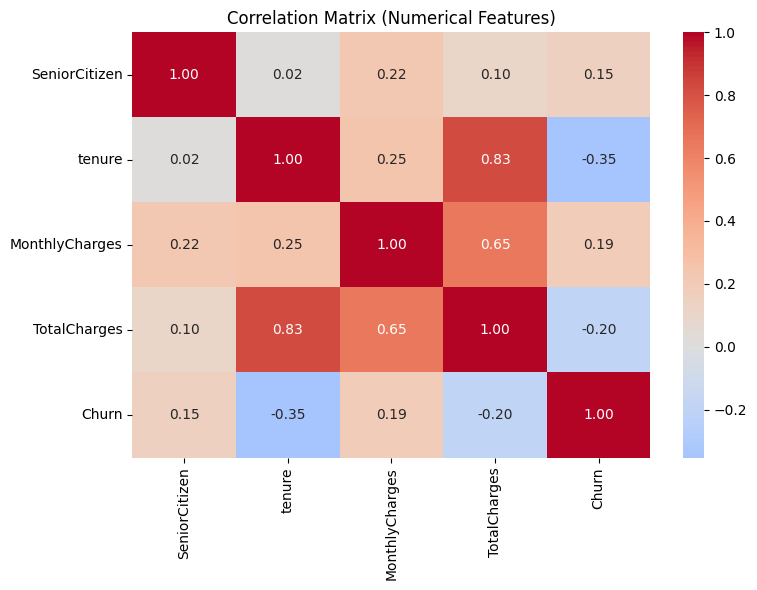


Top correlations with Churn:
Churn             1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
TotalCharges     -0.199037
tenure           -0.352229
Name: Churn, dtype: float64

3. DATA PREPROCESSING
------------------------------
Features: 15 categorical, 4 numerical
Training set: (5634, 19) (Churn: 26.5%)
Test set: (1409, 19) (Churn: 26.5%)
Class weights: {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}

4. DECISION TREE MODEL
------------------------------
Training Decision Tree with GridSearchCV...
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV F1 score: 0.5703

Test Performance:
Accuracy:  0.7970
Recall:    0.5668
Precision: 0.6310
F1-Score:  0.5972
ROC-AUC:   0.8312


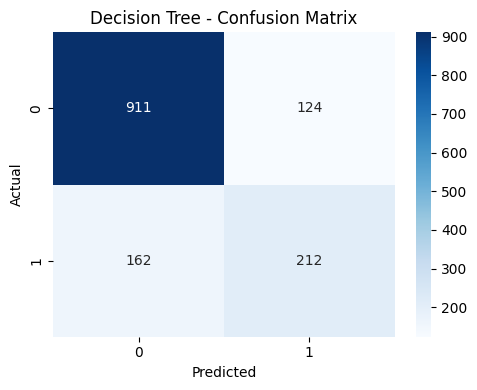


DECISION TREE DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.85      0.88      0.86      1035
       Churn       0.63      0.57      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409


5. NEURAL NETWORK MODEL
------------------------------
Testing Neural Network architectures...

Architecture 1: [32, 16] units
  Validation AUC: 0.8470

Architecture 2: [64, 32] units
  Validation AUC: 0.8445

Architecture 3: [128, 64, 32] units
  Validation AUC: 0.8465

Best architecture: [32, 16] units
Best validation AUC: 0.8470

Training best Neural Network on full training set...

Test Performance:
Accuracy:  0.7587
Recall:    0.7353
Precision: 0.5329
F1-Score:  0.6180
ROC-AUC:   0.8397


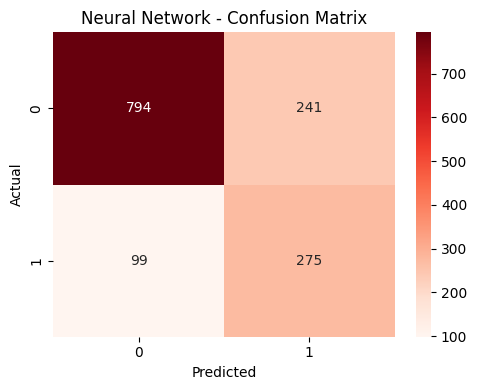


NEURAL NETWORK DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Churn       0.89      0.77      0.82      1035
       Churn       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409


6. MODEL COMPARISON
------------------------------

=== PERFORMANCE COMPARISON ===

   Metric  Decision Tree  Neural Network
 Accuracy       0.797019        0.758694
   Recall       0.566845        0.735294
Precision       0.630952        0.532946
 F1-Score       0.597183        0.617978
  ROC-AUC       0.831234        0.839709

=== ROC CURVES ===


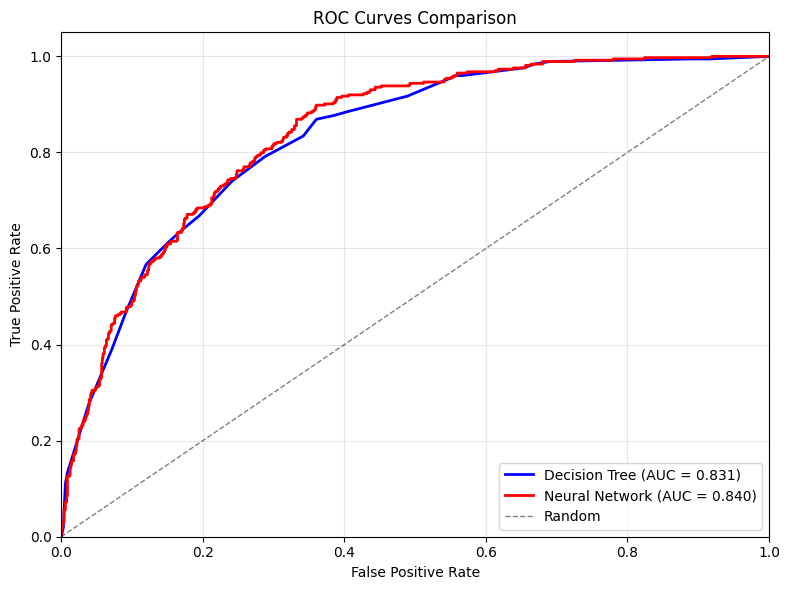


=== MODEL CHARACTERISTICS ===

Decision Tree:
  • Best depth: 5
  • Criterion: entropy
  • Interpretability: High (rules can be extracted)
  • Training time: Fast

Neural Network:
  • Best architecture: [32, 16] units
  • Learning rate: 0.001
  • Interpretability: Low (black box)
  • Training time: Moderate

=== DETAILED WEIGHTED AVERAGES COMPARISON ===
------------------------------------------------------------

            Metric  Decision Tree  Neural Network
Weighted Precision          0.791           0.795
   Weighted Recall          0.797           0.759
 Weighted F1-Score          0.793           0.769

=== RECOMMENDATION ===
✅ Neural Network recommended for deployment
   Reason: Higher F1-Score (0.618 vs 0.597)
   • Neural Network better at catching churners (Recall: 0.735)
   • Decision Tree has better weighted F1-score (0.793 vs 0.769)

7. SUMMARY
------------------------------
✓ Results saved to 'outputs/model_results.csv'

✓ Classification reports with weighted averages d

In [3]:
# TELCO CHURN PREDICTION

#imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Core libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Create minimal output structure
os.makedirs("outputs", exist_ok=True)

print("=" * 60)
print("TELCO CHURN PREDICTION - COURSEWORK IMPLEMENTATION")
print("=" * 60)

# 1. DATA LOADING & BASIC CLEANING
print("\n1. LOADING AND CLEANING DATA")
print("-" * 30)

# Load data
df = pd.read_csv("/content/sample_data/Telco-Customer-Churn.csv")
print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")

# Basic cleaning
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Handle missing values
if df['TotalCharges'].isnull().sum() > 0:
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# 2. ESSENTIAL EDA (3 VISUALIZATIONS ONLY)
print("\n2. ESSENTIAL EXPLORATORY ANALYSIS")
print("-" * 30)

# 2.1 Target Distribution (CRITICAL)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
churn_counts = df['Churn'].value_counts()
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='viridis')
plt.title('Churn Distribution')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(churn_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
        colors=['lightblue', 'lightcoral'])
plt.title('Churn Percentage')

plt.tight_layout()
plt.savefig('outputs/churn_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Churn rate: {df['Churn'].mean():.1%} ({churn_counts[1]}/{churn_counts[0]+churn_counts[1]})")

# 2.2 Most Important Feature: Tenure
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, bins=30)
plt.title('Tenure Distribution by Churn Status')
plt.xlabel('Tenure (months)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('outputs/tenure_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# 2.3 Simple Correlation Heatmap (Numerical features only)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numerical Features)')
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTop correlations with Churn:")
print(corr_matrix['Churn'].sort_values(ascending=False).head(5))

# 3. DATA PREPROCESSING WITH STRATIFY + CLASS WEIGHTS
print("\n3. DATA PREPROCESSING")
print("-" * 30)

# Prepare features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Features: {len(cat_cols)} categorical, {len(num_cols)} numerical")

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols)
])

# Split with STRATIFY (preserve imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape} (Churn: {y_train.mean():.1%})")
print(f"Test set: {X_test.shape} (Churn: {y_test.mean():.1%})")

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Calculate CLASS WEIGHTS
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# 4. DECISION TREE WITH HYPERPARAMETER TUNING
print("\n4. DECISION TREE MODEL")
print("-" * 30)

# Define simple but effective parameter grid
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# GridSearch with Stratified K-Fold
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=0
)

print("Training Decision Tree with GridSearchCV...")
dt_grid.fit(X_train_processed, y_train)

print(f"Best parameters: {dt_grid.best_params_}")
print(f"Best CV F1 score: {dt_grid.best_score_:.4f}")

# Get best model
best_dt = dt_grid.best_estimator_

# Evaluate on test set
y_pred_dt = best_dt.predict(X_test_processed)
y_pred_proba_dt = best_dt.predict_proba(X_test_processed)[:, 1]

dt_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'recall': recall_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_dt)
}

print("\nTest Performance:")
print(f"Accuracy:  {dt_metrics['accuracy']:.4f}")
print(f"Recall:    {dt_metrics['recall']:.4f}")
print(f"Precision: {dt_metrics['precision']:.4f}")
print(f"F1-Score:  {dt_metrics['f1']:.4f}")
print(f"ROC-AUC:   {dt_metrics['roc_auc']:.4f}")

# Save confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('outputs/dt_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# 4.1 DECISION TREE DETAILED CLASSIFICATION REPORT
print("\n" + "=" * 60)
print("DECISION TREE DETAILED CLASSIFICATION REPORT")
print("=" * 60)

dt_report = classification_report(y_test, y_pred_dt, target_names=['No Churn', 'Churn'], digits=2)
print(dt_report)

# 5. NEURAL NETWORK WITH HYPERPARAMETER EXPLORATION
print("\n5. NEURAL NETWORK MODEL")
print("-" * 30)

# Define different architectures to test
architectures = [
    # Simple network
    {'units': [32, 16], 'dropout': 0.2, 'lr': 0.001},
    # Medium network
    {'units': [64, 32], 'dropout': 0.3, 'lr': 0.0005},
    # Deeper network
    {'units': [128, 64, 32], 'dropout': 0.4, 'lr': 0.0001}
]

# Create validation split for NN
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_processed, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

best_nn_model = None
best_val_auc = 0
best_arch = None

print("Testing Neural Network architectures...")

for i, arch in enumerate(architectures):
    print(f"\nArchitecture {i+1}: {arch['units']} units")

    # Build model
    model = Sequential()
    model.add(Dense(arch['units'][0], activation='relu',
                   input_dim=X_train_processed.shape[1]))
    model.add(Dropout(arch['dropout']))

    for units in arch['units'][1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(arch['dropout']))

    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=arch['lr']),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    # Train with early stopping
    history = model.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_val_nn, y_val_nn),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        class_weight=class_weight_dict,
        verbose=0
    )

    # Get validation AUC
    val_auc = history.history['val_auc'][-1]
    print(f"  Validation AUC: {val_auc:.4f}")

    # Track best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_nn_model = model
        best_arch = arch

print(f"\nBest architecture: {best_arch['units']} units")
print(f"Best validation AUC: {best_val_auc:.4f}")

# Train best model on full training data
print("\nTraining best Neural Network on full training set...")
best_nn_model.fit(
    X_train_processed, y_train,
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=0
)

# Evaluate on test set
y_pred_proba_nn = best_nn_model.predict(X_test_processed, verbose=0).flatten()
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int)

nn_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'recall': recall_score(y_test, y_pred_nn),
    'precision': precision_score(y_test, y_pred_nn),
    'f1': f1_score(y_test, y_pred_nn),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_nn)
}

print("\nTest Performance:")
print(f"Accuracy:  {nn_metrics['accuracy']:.4f}")
print(f"Recall:    {nn_metrics['recall']:.4f}")
print(f"Precision: {nn_metrics['precision']:.4f}")
print(f"F1-Score:  {nn_metrics['f1']:.4f}")
print(f"ROC-AUC:   {nn_metrics['roc_auc']:.4f}")

# Save confusion matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Reds')
plt.title('Neural Network - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('outputs/nn_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# 5.1 NEURAL NETWORK DETAILED CLASSIFICATION REPORT
print("\n" + "=" * 60)
print("NEURAL NETWORK DETAILED CLASSIFICATION REPORT")
print("=" * 60)

nn_report = classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn'], digits=2)
print(nn_report)

# 6. ESSENTIAL MODEL COMPARISON
print("\n6. MODEL COMPARISON")
print("-" * 30)

# 6.1 Performance Metrics Table
print("\n=== PERFORMANCE COMPARISON ===")
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'Precision', 'F1-Score', 'ROC-AUC'],
    'Decision Tree': [
        dt_metrics['accuracy'],
        dt_metrics['recall'],
        dt_metrics['precision'],
        dt_metrics['f1'],
        dt_metrics['roc_auc']
    ],
    'Neural Network': [
        nn_metrics['accuracy'],
        nn_metrics['recall'],
        nn_metrics['precision'],
        nn_metrics['f1'],
        nn_metrics['roc_auc']
    ]
})

print("\n" + comparison_df.to_string(index=False))

# 6.2 ROC Curves Comparison
print("\n=== ROC CURVES ===")

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = dt_metrics['roc_auc']

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
roc_auc_nn = nn_metrics['roc_auc']

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, 'b-', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot(fpr_nn, tpr_nn, 'r-', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/roc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 6.3 Model Characteristics
print("\n=== MODEL CHARACTERISTICS ===")
print("\nDecision Tree:")
print(f"  • Best depth: {dt_grid.best_params_.get('max_depth', 'None')}")
print(f"  • Criterion: {dt_grid.best_params_.get('criterion')}")
print(f"  • Interpretability: High (rules can be extracted)")
print(f"  • Training time: Fast")

print("\nNeural Network:")
print(f"  • Best architecture: {best_arch['units']} units")
print(f"  • Learning rate: {best_arch['lr']}")
print(f"  • Interpretability: Low (black box)")
print(f"  • Training time: Moderate")

# 6.4 Detailed Weighted Averages Comparison
print("\n=== DETAILED WEIGHTED AVERAGES COMPARISON ===")
print("-" * 60)

# Get detailed metrics for weighted averages
dt_precision, dt_recall, dt_f1, dt_support = precision_recall_fscore_support(y_test, y_pred_dt, average=None)
dt_weights = dt_support / np.sum(dt_support)
dt_weighted_precision = np.sum(dt_precision * dt_weights)
dt_weighted_recall = np.sum(dt_recall * dt_weights)
dt_weighted_f1 = np.sum(dt_f1 * dt_weights)

nn_precision, nn_recall, nn_f1, nn_support = precision_recall_fscore_support(y_test, y_pred_nn, average=None)
nn_weights = nn_support / np.sum(nn_support)
nn_weighted_precision = np.sum(nn_precision * nn_weights)
nn_weighted_recall = np.sum(nn_recall * nn_weights)
nn_weighted_f1 = np.sum(nn_f1 * nn_weights)

weighted_comparison = pd.DataFrame({
    'Metric': ['Weighted Precision', 'Weighted Recall', 'Weighted F1-Score'],
    'Decision Tree': [dt_weighted_precision, dt_weighted_recall, dt_weighted_f1],
    'Neural Network': [nn_weighted_precision, nn_weighted_recall, nn_weighted_f1]
})

print("\n" + weighted_comparison.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# 6.5 Practical Recommendation
print("\n=== RECOMMENDATION ===")

if nn_metrics['f1'] > dt_metrics['f1']:
    print("✅ Neural Network recommended for deployment")
    print(f"   Reason: Higher F1-Score ({nn_metrics['f1']:.3f} vs {dt_metrics['f1']:.3f})")
else:
    print("✅ Decision Tree recommended for deployment")
    print(f"   Reason: Higher F1-Score ({dt_metrics['f1']:.3f} vs {nn_metrics['f1']:.3f})")

# Check recall (important for churn prediction)
if nn_metrics['recall'] > dt_metrics['recall']:
    print(f"   • Neural Network better at catching churners (Recall: {nn_metrics['recall']:.3f})")
else:
    print(f"   • Decision Tree better at catching churners (Recall: {dt_metrics['recall']:.3f})")

# Check weighted F1-score
if nn_weighted_f1 > dt_weighted_f1:
    print(f"   • Neural Network has better weighted F1-score ({nn_weighted_f1:.3f} vs {dt_weighted_f1:.3f})")
else:
    print(f"   • Decision Tree has better weighted F1-score ({dt_weighted_f1:.3f} vs {nn_weighted_f1:.3f})")

# 7. SUMMARY AND SAVING RESULTS
print("\n7. SUMMARY")
print("-" * 30)

# Save metrics to CSV
results_df = pd.DataFrame({
    'Decision_Tree': dt_metrics,
    'Neural_Network': nn_metrics
}).T

# Add weighted averages to results
results_df['weighted_precision'] = [dt_weighted_precision, nn_weighted_precision]
results_df['weighted_recall'] = [dt_weighted_recall, nn_weighted_recall]
results_df['weighted_f1'] = [dt_weighted_f1, nn_weighted_f1]

results_df.to_csv('outputs/model_results.csv')
print("✓ Results saved to 'outputs/model_results.csv'")

print("\n✓ Classification reports with weighted averages displayed above")
print("✓ All visualizations saved to 'outputs/' folder")
print("=" * 60)
